In [1]:
import requests
from bs4 import BeautifulSoup
import pandas as pd
import numpy as np
import sqlite3 as sql3
import matplotlib.pyplot as plt

In [2]:
# Get data from URL

url      = "https://en.wikipedia.org/wiki/List_of_Grand_Slam_men%27s_singles_champions#Champions_list"
response = requests.get(url,headers={"User-Agent": "Mozilla/5.0 (Macintosh; Intel Mac OS X 10_11_5) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/50.0.2661.102 Safari/537.36"})

# Extract content from the response

hyperText = BeautifulSoup(response.content,'html.parser')

# Find relevant anchor points in the HTML
dataTable = hyperText.find('table',class_="wikitable sortable mw-datatable sticky-header sort-under-center")

# Get table headers
headers = []
for hi in dataTable.find_all('th')[0:9]:
    headers.append(hi.get_text().strip().replace('\xad', '')) # Remove potential soft hyphenation

# Replace 'AE' and 'OE' headers for readability

headers[2] = 'Amateur Era'
headers[3] = 'Open Era'

# Loop through all the data

rowData = []

for idx in range(0,40):
        rowInfo = []
        ri = dataTable.find_all('tr')[1:][idx].find_all('th')
        
        # The table has an attribute called "rowspan" that repeats the number of titles if a player
        # has the same number of Grand Slams won. This is not stored in the tag <th> as player with
        # a unique number of won Grand Slam; it returns an empty list so the next piece of code 
        # stores the repeated value and appends it into the list
        
        if ri: # For pieces of the HTML where th is not empty
            if 'rowspan' in ri[0].attrs: # where the attribute 'rowspan' exists
                repGS   = ri[0].get_text().replace('\n',"") # Get the missing value in the next players
                rii     = dataTable.find_all('tr')[1:][idx].find_all(['th','td'])[0:10]
                rowInfo = [riii.get_text().replace('\n',"") for riii in rii]
            else: # For players with unique values
                rii     = dataTable.find_all('tr')[1:][idx].find_all(['th','td'])[0:10]
                rowInfo = [riii.get_text().replace('\n',"") for riii in rii]
            if rowInfo:
                 rowData.append(rowInfo)
        else: # For players that share the same number of Grand Slams
            rii     = dataTable.find_all('tr')[1:][idx].find_all('td')[0:10]
            rowInfo = [riii.get_text().replace('\n',"") for riii in rii]
            rowInfo.insert(0,repGS)
            if rowInfo:
                rowData.append(rowInfo)

In [3]:
# Generate data frame

dfGS = pd.DataFrame(rowData,columns=headers)

# Inserting a ranking column
dfGS.insert(loc=0,column='Rank',value=(np.linspace(1,40,40,endpoint=True,dtype=int)))
dfGS['Titles']          = dfGS['Titles'].astype('int')
dfGS['Australian Open'] = dfGS['Australian Open'].astype('int')
dfGS['French Open']     = dfGS['French Open'].astype('int')
dfGS['Wimbledon']       = dfGS['Wimbledon'].astype('int')
dfGS['US Open']         = dfGS['US Open'].astype('int')
dfGS['Amateur Era']     = dfGS['Amateur Era'].astype('int',errors='ignore')


In [4]:
# Convert data frame to SQL

connection = sql3.connect("web_db.db")

# Load data to SQL

#dfGS.to_sql("tennis",connection)
cursor = connection.cursor()
pd.read_sql_query(" SELECT * FROM tennis",connection)

,index,Rank,Titles,Player,Amateur Era,Open Era,Australian Open,French Open,Wimbledon,US Open,Years
0,0,1,24,Novak Djokovic,N/A,24,10,3,7,4,2008–2023
1,1,2,22,Rafael Nadal,N/A,22,2,14,2,4,2005–2022
2,2,3,20,Roger Federer,N/A,20,6,1,8,5,2003–2018
3,3,4,14,Pete Sampras,N/A,14,2,0,7,5,1990–2002
4,4,5,12,Roy Emerson,12,N/A,6,2,2,2,1961–1967
5,5,6,11,Rod Laver,6,5,3,2,4,2,1960–1969
6,6,7,11,Björn Borg,N/A,11,0,6,5,0,1974–1981
7,7,8,10,Bill Tilden,10,N/A,0,0,3,7,1920–1930
8,8,9,8,Fred Perry,8,N/A,1,1,3,3,1933–1936
9,9,10,8,Ken Rosewall,4,4,4,2,0,2,1953–1972


In [ ]:
dfGS["Australian Open","French Open","Wimbledon","US Open"]

,French Open,US Open
0,3,4
1,14,4
2,1,5
3,0,5
4,2,2
5,2,2
6,6,0
7,0,7
8,1,3
9,2,2


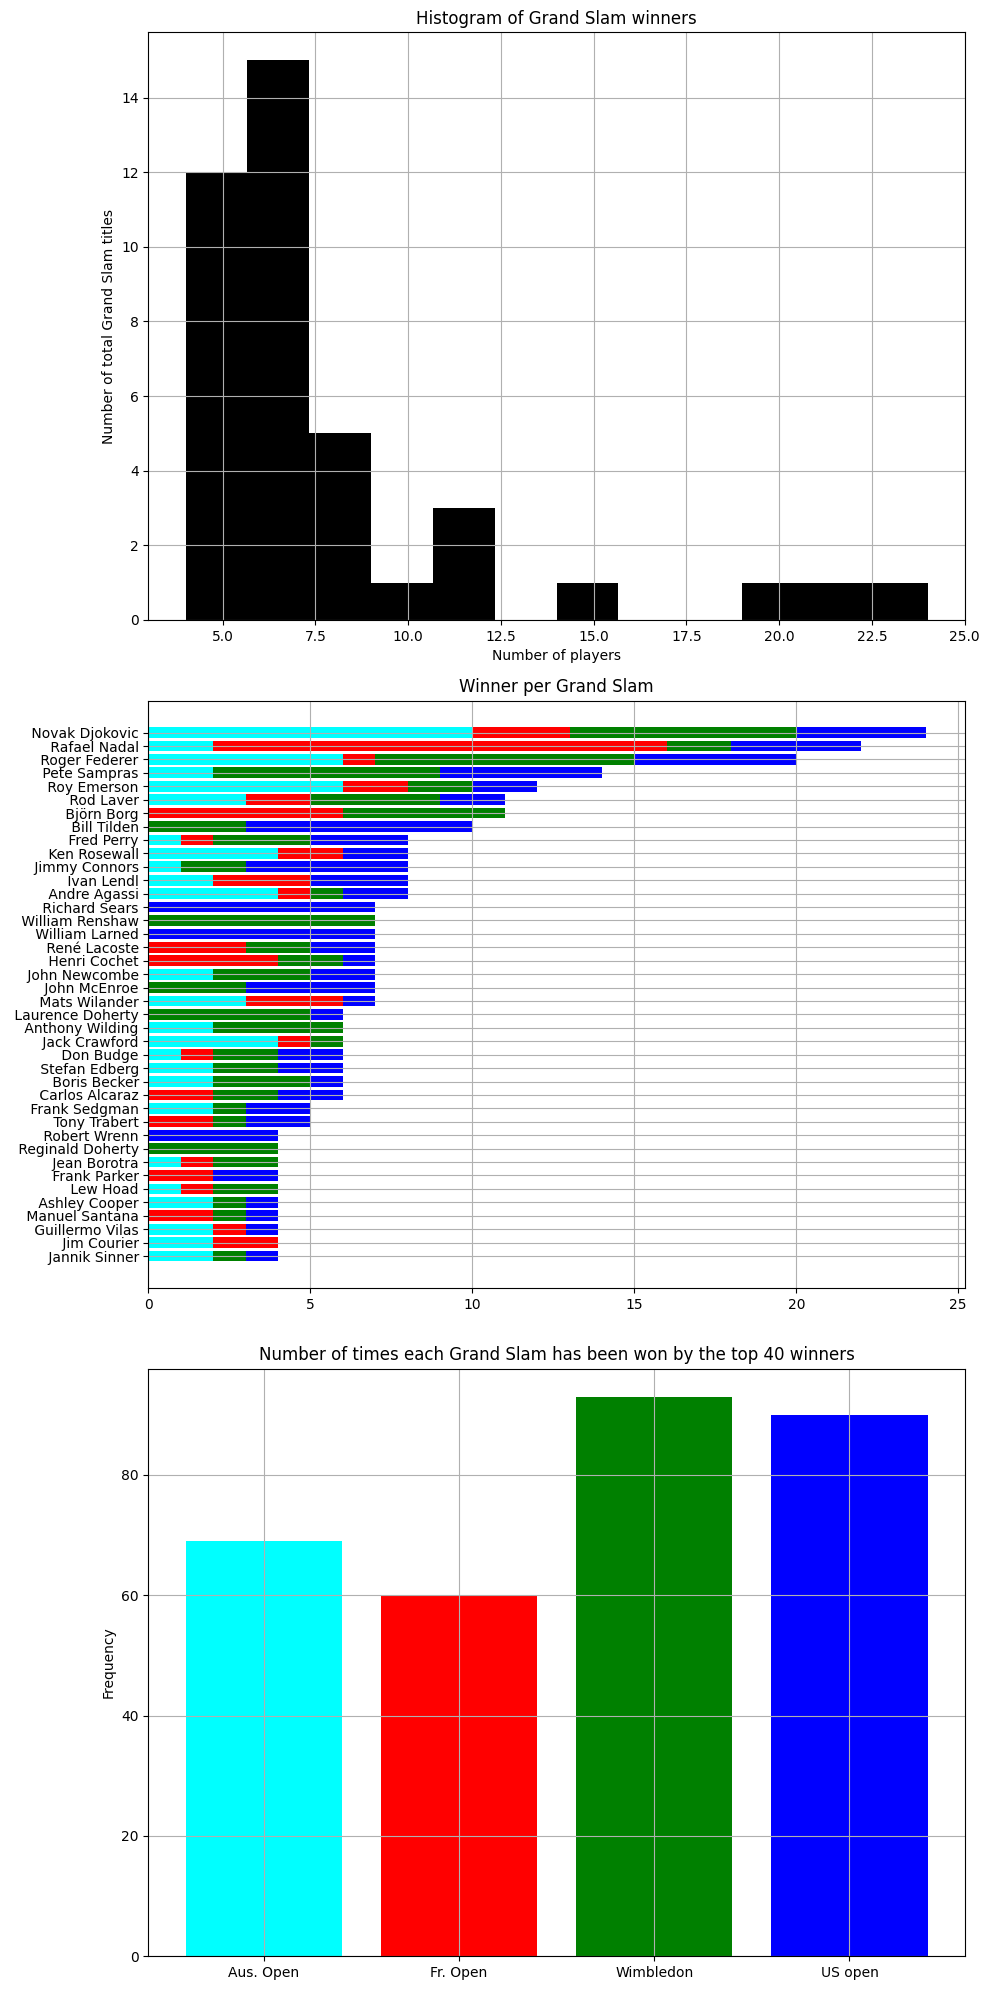

In [46]:
# Data visualization

fig, (ax0,ax1,ax2) = plt.subplots(nrows=3,ncols=1,figsize=(10,20))

# Histogram of Grand Slam winners

ax0.hist(dfGS["Titles"],bins=12,color='black')
ax0.set_xlabel('Number of players')
ax0.set_ylabel('Number of total Grand Slam titles')
ax0.set_title('Histogram of Grand Slam winners')
ax0.grid()

# Bar plot of number of winners per Grand Slam

AO = dfGS["Australian Open"][::-1]
FO = dfGS["French Open"][::-1]
WO = dfGS["Wimbledon"][::-1]
US = dfGS["US Open"][::-1]

pos = np.arange(len(dfGS["Player"][::-1]))

ax1.barh(pos, AO, label="Australian Open",color='cyan')
ax1.barh(pos, FO, left=AO, label="French Open",color='red')
ax1.barh(pos, WO, left=AO+FO, label="Wimbledon",color='green')
ax1.barh(pos, US, left=AO+FO+WO, label="US Open",color='blue')
ax1.set_yticks(pos, dfGS["Player"][::-1])
ax1.set_title('Winner per Grand Slam')
ax1.grid()

# Most and least won Grand Slam

dfGS_total = dfGS.groupby(by="Player")[["Australian Open","French Open","Wimbledon","US Open"]].apply(lambda x: x).sum()

ax2.bar(np.arange(4),dfGS_total.to_list(),color=['cyan','red','green','blue'])
ax2.set_xticks([0,1,2,3],['Aus. Open','Fr. Open','Wimbledon','US open'])
ax2.set_ylabel('Frequency')
ax2.set_title('Number of times each Grand Slam has been won by the top 40 winners')
ax2.grid()

plt.tight_layout()
plt.show()

